# **Predicción de género cinematográfico con PLN clásico**

In [ ]:
!pip install spacy tqdm pandas scikit-learn matplotlib seaborn textblob
!python -m spacy download es_core_news_sm
!pip install -q -U google-genai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 30.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import spacy
import string

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from tqdm import tqdm

#API
import google.generativeai as genai
import os


# Configuración visual
pd.set_option('display.max_colwidth', 200)
sns.set(style="whitegrid", palette="pastel")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Montar Google Drive y cargar el CSV desde tu carpeta PLN_Proyecto
from google.colab import drive
drive.mount('/content/drive')

# Ruta a tu archivo (ajusta el nombre del CSV real)
file_path = "/content/drive/MyDrive/PLN_Proyecto/data/films_clean.csv"

# Cargar el dataset
df = pd.read_csv(file_path)

print("Dimensiones:", df.shape)
df.head()


Mounted at /content/drive
Dimensiones: (5332, 6)


,film_name,film_avg_rate,review_rate,review_title,review_text,gender
0,La liberación,4.5,5,"Bien, sin más...Me voy raudo y veloz a ver The Exorcist. Quizás vaya ya por la vez número 100.","""Desde que hace ya más de 50 años que William Peter Blatty primero y, William Friedkin después, concibieran el mito de The Exorcist, nunca jamás nada volvió a ser igual. Decenas de producciones he...","['Terror', 'Intriga']"
1,La liberación,4.5,1,"Tenemos versión cristiana, evangélica …cuándo la de cienciología?","Ya la has visto antes de verla en otras 200 películas del mismo estilo que salieron post El Exorcista, y lo único que tiene de nuevo es que es una versión hecha por y para evangelistas. Nada abso...","['Terror', 'Intriga']"
2,La liberación,4.5,1,Esto no es terror amigos,"""Hay que puntualizar que no es una peli de terror, sino un dramón barato digno de antena 3 a la hora de la sobremesa. """"La Ebony"""" (se han comido el tarro con el nombre el guionista) de hortaleza ...","['Terror', 'Intriga']"
3,La liberación,4.5,4,Liberación la nuestra,"La carrera de Lee Daniels es cuanto menos irregular. Desde la muy sobrevalorada Precious hasta El mayordomo, quizás lo más brillante de su filmografía sea el biopic de Billie Holiday, que ya tenía...","['Terror', 'Intriga']"
4,La liberación,4.5,2,El terror que nunca llega,"""Intenta sumergirnos en el clásico subgénero del terror de casas encantadas, mezclando elementos sobrenaturales con un trasfondo de intriga. La trama sigue a una familia que se muda a una casa en ...","['Terror', 'Intriga']"


La columna gender tiene listas como texto **("['Terror', 'Intriga']")**, así que primero hay que convertirlas a listas reales de Python

In [ ]:
import ast

def safe_eval(val):
    return val if isinstance(val, list) else ast.literal_eval(val)

df['gender'] = df['gender'].apply(safe_eval)

df[['film_name', 'gender']].head(10)


,film_name,gender
0,La liberación,"[Terror, Intriga]"
1,La liberación,"[Terror, Intriga]"
2,La liberación,"[Terror, Intriga]"
3,La liberación,"[Terror, Intriga]"
4,La liberación,"[Terror, Intriga]"
5,La liberación,"[Terror, Intriga]"
6,La liberación,"[Terror, Intriga]"
7,La liberación,"[Terror, Intriga]"
8,La liberación,"[Terror, Intriga]"
9,Príncipes salvajes,[Drama]


# **Análisis Exploratorio Inicial**

In [ ]:
# Combinaciones únicas de géneros que existen en el dataset
df['gender'].apply(tuple).value_counts().head(15)

,count
gender,
"(Comedia, Drama, Ciencia ficción)",320
"(Thriller, Drama)",291
"(Drama, Aventuras)",271
"(Western, Drama)",229
"(Intriga, Thriller, Drama)",204
"(Thriller, Intriga, Crimen)",141
"(Bélico, Acción, Drama)",138
"(Drama,)",128
"(Intriga, Comedia, Crimen)",125


Las combinaciones más comunes son:

- (Comedia, Drama, Ciencia ficción) → 320 casos

- (Thriller, Drama) → 291 casos

- (Drama, Aventuras) → 271 casos

También hay muchas combinaciones con 3 géneros, lo que sugiere que el modelo debe aprender interacciones entre géneros.

**Esto permite decidir si se va a entrenar el modelo para predecir géneros individuales o combinaciones completas (lo más común es predecir géneros individuales).**

num_genres
3    2253
2    1949
4     509
1     460
5     156
6       3
8       2
Name: count, dtype: int64


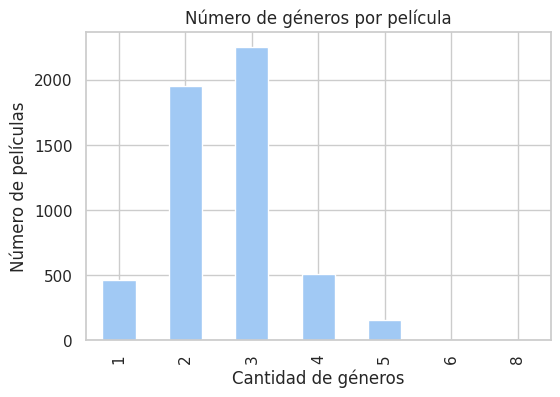

In [ ]:
# Número de géneros por película
df['num_genres'] = df['gender'].apply(len)

# Distribución
print(df['num_genres'].value_counts())

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['num_genres'].value_counts().sort_index().plot(kind='bar')
plt.title("Número de géneros por película")
plt.xlabel("Cantidad de géneros")
plt.ylabel("Número de películas")
plt.show()


- La mayoría de las películas tienen 2 o 3 géneros (más de 4000 casos combinados).

- olo 460 películas tienen un solo género.

- **Casos con 5 o más géneros son muy raros → pueden ser ruidosos o difíciles de clasificar.**

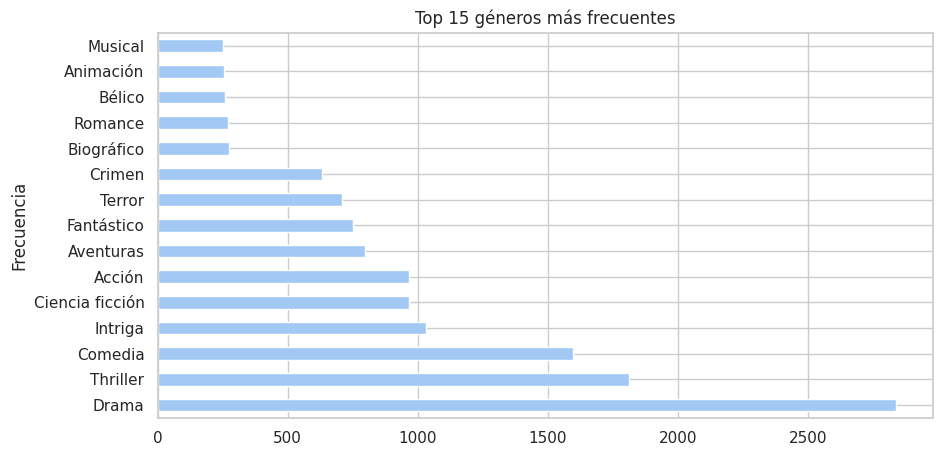

In [ ]:
from collections import Counter

# Flatten de todas las listas
all_genres = [g for sublist in df['gender'] for g in sublist]
genre_counts = Counter(all_genres)

# Mostrar los 15 más frecuentes
import pandas as pd
pd.Series(genre_counts).sort_values(ascending=False).head(15).plot(kind='barh', figsize=(10,5))
plt.title("Top 15 géneros más frecuentes")
plt.ylabel("Frecuencia")
plt.show()


In [ ]:
# Filtrar ejemplos con 'Terror'
ej_terror = df[df['gender'].apply(lambda x: 'Terror' in x)].head(3)

# Mostrar texto y géneros
for i, row in ej_terror.iterrows():
    print(f"\nTítulo: {row['film_name']}")
    print(f"Géneros: {row['gender']}")
    print(f"Reseña: {row['review_text'][:300]}...")



Título: La liberación 
Géneros: ['Terror', 'Intriga']
Reseña: "Desde que hace ya más de 50 años que William Peter Blatty primero y, William Friedkin después, concibieran el mito de The Exorcist, nunca jamás nada volvió a ser igual. Decenas de producciones hechas, las cuales, ni siquiera han conseguido rozar el acercamiento a The Exorcist.Ello no quita que haya...

Título: La liberación 
Géneros: ['Terror', 'Intriga']
Reseña: Ya la has visto antes de verla en otras 200 películas del mismo estilo que salieron post El Exorcista, y lo único que tiene de nuevo es que  es una versión hecha por y para evangelistas. Nada absolutamente nada nuevo en este diablo que trepa paredes como Spiderman.La única que se salva en todo este ...

Título: La liberación 
Géneros: ['Terror', 'Intriga']
Reseña: "Hay que puntualizar que no es una peli de terror, sino un dramón barato digno de antena 3 a la hora de la sobremesa. ""La Ebony"" (se han comido el tarro con el nombre el guionista) de hortaleza sufrido

Las reseñas mencionan elementos clásicos del terror y la intriga, lo que valida que el modelo puede aprender a asociar texto con géneros.

In [ ]:
# Mostrar ejemplos por género
def mostrar_ejemplos(género, n=3):
    ejemplos = df[df['gender'].apply(lambda x: género in x)].head(n)
    for i, row in ejemplos.iterrows():
        print(f"\n🎬 Título: {row['film_name']}")
        print(f"🎭 Géneros: {row['gender']}")
        print(f"📝 Reseña: {row['review_text'][:300]}...")

# Ejemplos variados
for g in ['Drama', 'Comedia', 'Ciencia ficción', 'Crimen', 'Romance']:
    print(f"\n🔎 Ejemplos para género: {g}")
    mostrar_ejemplos(g)



🔎 Ejemplos para género: Drama

🎬 Título: Príncipes salvajes 
🎭 Géneros: ['Drama']
📝 Reseña: América Latina es el continente más desigual del mundo. África presenta mayores niveles de pobreza, pero en América Latina es donde las diferencias de clase resultan mas sangrantes. Con un porcentaje de la sociedad de personas ricas que viven en el lujo y la opulencia y una gran mayoría del pueblo q...

🎬 Título: Pretty Guardian Sailor Moon Cosmos: La película 
🎭 Géneros: ['Animación', 'Fantástico', 'Acción', 'Comedia', 'Drama', 'Aventuras', 'Romance', 'Terror']
📝 Reseña: Sailor Moon ha sido desde los 90' uno de mis animes favoritos, y creo que uno de los primeros que vi (antes de saber que se les llamaba anime), aunque la versión de los 90' no era fiel al manga y era un poco repetitiva, me pareció una muy buena adaptación que disfruté muchísimo hasta el capítulo fin...

🎬 Título: Pretty Guardian Sailor Moon Cosmos: La película 
🎭 Géneros: ['Animación', 'Fantástico', 'Acción', 'Comedia', 'Drama

Se seleccionaron ejemplos representativos de reseñas para géneros frecuentes como Drama, Comedia, Ciencia ficción, Crimen y Romance. En cada caso, se observó que el texto contiene elementos temáticos, estilísticos y narrativos coherentes con el género asignado. Esta validación confirma que las reseñas son una fuente adecuada para inferir géneros mediante técnicas de PLN.


- Las reseñas de Drama hablan de desigualdad social, conflictos humanos, introspección → coherente con el género.

- Las de Comedia usan humor adolescente, referencias sexuales, tono ligero → claramente cómico.

- Las de Ciencia ficción mencionan directores, universos, tecnología, referencias a Star Wars → muy representativas.

- Las de Crimen hablan de detectives, corrupción, persecuciones → semántica típica del género.

- Las de Romance incluyen relaciones, emociones, nostalgia, vínculos afectivos → bien alineadas.

En resumen los textos contienen:

- **Diversidad semántica:** cada género tiene un estilo, vocabulario y enfoque distinto.

- **Combinaciones reales:** muchas reseñas tienen múltiples géneros, lo que valida el enfoque multietiqueta.

- **Contexto narrativo:** las reseñas no solo describen la trama, sino también el tono, el ritmo y la atmósfera — todo útil para inferir género.

Esto demuestra que el modelo puede aprender a asociar texto con géneros, incluso cuando hay varios simultáneamente.

In [ ]:
# Verificar valores nulos
print(df.isnull().sum())

# Verificar si hay textos vacíos
print("Textos vacíos:", (df['review_text'].str.strip() == '').sum())


film_name        0
film_avg_rate    0
review_rate      0
review_title     0
review_text      0
gender           0
num_genres       0
dtype: int64
Textos vacíos: 0


count    5332.000000
mean      249.980683
std       191.271503
min         8.000000
25%       114.000000
50%       192.000000
75%       322.000000
max      1084.000000
Name: text_length, dtype: float64


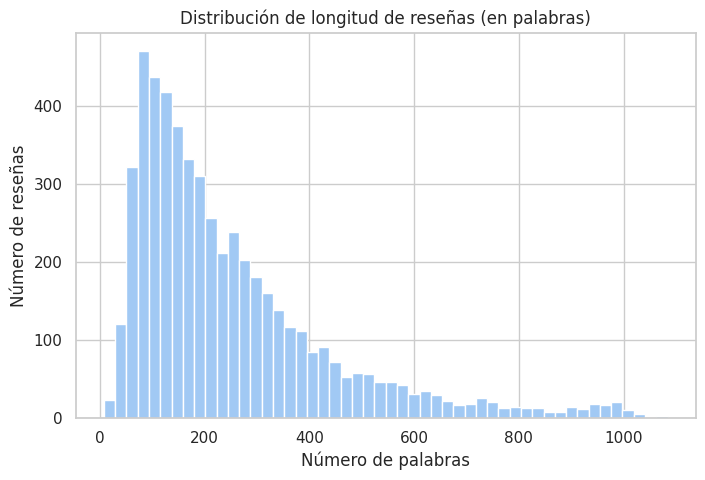

In [ ]:
# Longitud de cada reseña
df['text_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Estadísticas descriptivas
print(df['text_length'].describe())

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
df['text_length'].hist(bins=50)
plt.title("Distribución de longitud de reseñas (en palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Número de reseñas")
plt.show()


- Distribución: sesgada a la derecha (muchas reseñas entre 100 – 300 palabras, pocas muy largas)

- Mínimo: 8 palabras → se podría considerar eliminar reseñas muy cortas si no aportan semántica útil.

In [ ]:
# Calcular longitud en palabras
df['text_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Filtrar reseñas con al menos 10 palabras
df = df[df['text_length'] >= 20].copy()

# Verificar nuevo tamaño
print("Nuevo tamaño del dataset después de filtrar reseñas cortas:", df.shape)

# Longitud de cada reseña
df['text_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Estadísticas descriptivas
print(df['text_length'].describe())


Nuevo tamaño del dataset después de filtrar reseñas cortas: (5327, 8)
count    5327.000000
mean      250.202928
std       191.223540
min        21.000000
25%       114.000000
50%       192.000000
75%       322.000000
max      1084.000000
Name: text_length, dtype: float64


Se eliminaron del corpus todas las reseñas con menos de 10 palabras, dado que no aportan suficiente contenido semántico para inferir géneros de forma fiable. Esta decisión mejora la calidad del texto de entrada y reduce el ruido en el entrenamiento del modelo.

El umbral de longitud mínima se definió en función de la distribución de palabras por reseña. Dado que la mayoría de reseñas superan ampliamente las 100 palabras y solo un caso tenía menos de 10, se estableció un umbral conservador de 20 palabras. Este criterio elimina textos demasiado breves que carecen de información semántica, sin afectar significativamente el tamaño del corpus.


**Se optó por conservar todos los géneros presentes en el dataset, incluso aquellos con baja frecuencia, para preservar la riqueza semántica y la diversidad temática. En caso de que el modelo presente bajo rendimiento en géneros minoritarios, se aplicarán técnicas de data augmentation textual, oversampling multietiqueta y ajuste de penalización por clase para mejorar la capacidad de generalización sin comprometer la cobertura.**


# GENERADOR DE DATOS SINTÉTICOS ???

# **Preprocesamiento de etiquetas (géneros) :**

Las etiquetas de género se **binarizan** directamente mediante **MultiLabelBinarizer**, ya que son categorías discretas y no requieren normalización lingüística.

De esta manera, se obtiene una matriz de etiquetas (**y**)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Inicializar el binarizador
mlb = MultiLabelBinarizer()

# Ajustar y transformar la columna 'gender'
y = mlb.fit_transform(df['gender'])

# Ver los géneros detectados
print("Géneros posibles:", mlb.classes_)

# Convertir a DataFrame para visualizar mejor
y_df = pd.DataFrame(y, columns=mlb.classes_)

# Mostrar las primeras filas
print(y_df.head())


Géneros posibles: ['Acción' 'Animación' 'Aventuras' 'Biográfico' 'Bélico' 'Ciencia ficción'
 'Cine negro' 'Comedia' 'Comedia negra' 'Crimen' 'Documental' 'Drama'
 'Fantástico' 'Histórico' 'Intriga' 'Musical' 'Romance' 'Terror'
 'Thriller' 'Western']
   Acción  Animación  Aventuras  Biográfico  Bélico  Ciencia ficción  \
0       0          0          0           0       0                0   
1       0          0          0           0       0                0   
2       0          0          0           0       0                0   
3       0          0          0           0       0                0   
4       0          0          0           0       0                0   

   Cine negro  Comedia  Comedia negra  Crimen  Documental  Drama  Fantástico  \
0           0        0              0       0           0      0           0   
1           0        0              0       0           0      0           0   
2           0        0              0       0           0      0           0 

Las etiquetas de género se transformaron mediante MultiLabelBinarizer,
convirtiendo cada lista de géneros en un vector binario.
De esta forma, cada reseña queda representada por una fila en la matriz
y cada género por una columna, con valores 0/1 que indican su presencia.
Esta representación es necesaria para entrenar modelos multietiqueta
y evaluar métricas específicas por género.


# **Preprocesamiento de texto en reseñas cinematográficas**

Este proyecto aplica un pipeline de limpieza y procesamiento lingüístico diseñado para transformar reseñas en español en un corpus homogéneo y semánticamente útil para modelos de NLP y aprendizaje automático. Las decisiones se basan en la evidencia del propio corpus (exploración de frecuencias y auditorías posteriores), priorizando la coherencia conceptual del dominio cinematográfico.

---

## **1. Normalización inicial y reducción de ruido**

- **Minúsculas:** unifica la capitalización para reducir duplicados y variabilidad.
- **Eliminación de acentos:** sustituye vocales acentuadas por su forma sin tilde, manteniendo el significado y reduciendo el vocabulario.
- **Expansión de abreviaturas del dominio:** se mapean abreviaturas y coloquialismos frecuentes en reseñas:
  - Ejemplos: `"peli"` → `"pelicula"`, `"docu"` → `"documental"`, `"bio"` → `"biografico"`.
  - También se incluyen abreviaturas formales como `"sr."`, `"dra."`, `"etc."`, `"ee.uu."`.
- **Eliminación de ruido estructural:**
  - Textos entre corchetes, URLs, etiquetas HTML.
  - Signos de puntuación, saltos de línea, palabras con números.
  - Emojis y caracteres no ASCII (preservando la letra ñ).
- **Normalización de espacios:** colapsa espacios múltiples y recorta extremos.

> ⚠️ **Decisión clave:** se evita expandir contracciones como `"del"` → `"de el"` para prevenir la aparición artificial de tokens como `"él"` que contaminan el análisis.

---

## **2. Tokenización y filtrado lingüístico con spaCy**

- **Tokenización:** se realiza con el modelo `es_core_news_sm` de spaCy, que segmenta el texto en unidades lingüísticas con conocimiento del idioma.
- **Eliminación de stopwords:** se filtran con `token.is_stop` y se añade un conjunto manual de stopwords residuales detectadas empíricamente (`{"él"}`).
- **Longitud mínima:** se descartan tokens demasiado cortos (`min_len=3`), que tienden a ser ruido o poco informativos.
- **Salvaguardas de lematización:** se utiliza `token.lemma_`, pero si el lema contiene espacios (ej. `"c él él"`), se conserva el texto original (`token.text`) para evitar introducir artefactos.

---

## **3. Lematización y conservación de entidades nombradas**

- **Lematización contextual:** reduce las palabras a su forma base según morfología y contexto (ej. `"películas"` → `"película"`, `"volvió"` → `"volver"`), mejorando la coherencia semántica del corpus.
- **NER (entidades nombradas):** se preserva el texto superficial de tokens identificados como entidades relevantes:
  - Tipos: `PERSON`, `ORG`, `GPE`.
  - También se conserva el texto si el token tiene capitalización tipo título (`token.text.istitle()`).
  - Esto evita que nombres propios como `"Glenn Close"` se lematizen incorrectamente o se degraden a lemas no deseados.

---

## **4. Reconstrucción del texto limpio**

- **Construcción de `final_clean`:** se unen los tokens filtrados y lematizados en cadenas limpias, garantizando que el texto reconstruido refleje únicamente contenido semántico relevante.
- **Auditoría posterior:** se validan los resultados con conteos de frecuencia y nubes de palabras, verificando la ausencia de ruido funcional y la predominancia de términos temáticos como `"película"`, `"historia"`, `"personaje"`, `"escena"`, `"director"`, `"protagonista"`.

---

## **5. Justificación de decisiones aplicadas al corpus**

- **Enfoque corpus-driven:** las reglas (abreviaturas, stopwords extra) se fundamentan en la exploración de frecuencias y casos frontera detectados en la práctica.
- **Protección de nombres propios con NER:** se prioriza preservar entidades relevantes del dominio para no perder información útil (críticas, biopics, filmografías).
- **Evitar contracciones expandidas:** se previene la creación de tokens artificiales que perjudiquen la calidad semántica y la interpretación de resultados.

---

## **6. Preparación para extracción de características**

- **Base lista para vectorización:** la columna `final_clean` es adecuada para métodos como TF-IDF con n-gramas (1–2), lo que captura términos y co-ocurrencias relevantes del discurso cinematográfico.
- **Posible enriquecimiento:** puede extraerse una bolsa de entidades (PERSON, ORG, GPE) para complementar la representación del texto en tareas donde los nombres propios sean predictivos.



In [ ]:
# Diccionario de abreviaturas comunes y coloquiales
ABREVIATURAS = {
    "sr.": "señor",
    "sra.": "señora",
    "dr.": "doctor",
    "dra.": "doctora",
    "etc.": "etcetera",
    "p. ej.": "por ejemplo",
    "ee.uu.": "estados unidos",
    "dpto.": "departamento",
    "nro.": "numero",
    "núm.": "numero",
    "film.": "film",
    "dir.": "director",
    # coloquiales útiles en reseñas
    "peli": "pelicula",
    "docu": "documental",
    "bio": "biografico"
}

def limpiar_texto(text: str) -> str:
    """
    Preprocesa el texto realizando los siguientes pasos:
    1. Minúsculas.
    2. Eliminación de acentos de vocales.
    3. Expansión de abreviaturas (Sr.->Señor, peli->pelicula, etc.).
    4. Eliminación de textos entre corchetes.
    5. Eliminación de URLs.
    6. Eliminación de etiquetas HTML.
    7. Eliminación de signos de puntuación.
    8. Eliminación de saltos de línea.
    9. Eliminación de palabras con números.
    10. Eliminación de emojis y caracteres no ASCII (excepto ñ).
    11. Normalización de espacios y strip.

    Args:
        text: Texto original.

    Returns:
        Texto preprocesado y normalizado.
    """
    # 1) Minúsculas
    text = str(text).lower()

    # 2) Eliminar acentos de vocales
    MAP_VOCALES = {"á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u", "ü": "u"}
    text = text.translate(str.maketrans(MAP_VOCALES))

    # 3) Expansión de abreviaturas comunes y coloquiales
    for k, v in ABREVIATURAS.items():
        text = re.sub(rf"\b{re.escape(k)}\b", v, text)

    # 4) Eliminar textos entre corchetes
    text = re.sub(r"\[.*?\]", "", text)

    # 5) Eliminar URLs
    text = re.sub(r"https?://\S+|www\.\S+", "", text)

    # 6) Eliminar etiquetas HTML
    text = re.sub(r"<.*?>+", "", text)

    # 7) Eliminar signos de puntuación
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # 8) Eliminar saltos de línea
    text = re.sub(r"\n", " ", text)

    # 9) Eliminar palabras que contienen números (ej. abc123)
    text = re.sub(r"\w*\d\w*", "", text)

    # 10) Eliminar emojis y caracteres especiales (no ASCII), excepto ñ
    text = re.sub(r"[^\x00-\x7Fñ]+", "", text)

    # 11) Normalizar espacios múltiples y strip
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [ ]:
df["clean_review"] = df["review_text"].apply(limpiar_texto)

# Vista previa del resultado
df[['review_text', 'clean_review']].head()

,review_text,clean_review
0,"""Desde que hace ya más de 50 años que William Peter Blatty primero y, William Friedkin después, concibieran el mito de The Exorcist, nunca jamás nada volvió a ser igual. Decenas de producciones he...",desde que hace ya mas de años que william peter blatty primero y william friedkin despues concibieran el mito de the exorcist nunca jamas nada volvio a ser igual decenas de producciones hechas las...
1,"Ya la has visto antes de verla en otras 200 películas del mismo estilo que salieron post El Exorcista, y lo único que tiene de nuevo es que es una versión hecha por y para evangelistas. Nada abso...",ya la has visto antes de verla en otras peliculas del mismo estilo que salieron post el exorcista y lo unico que tiene de nuevo es que es una version hecha por y para evangelistas nada absolutamen...
2,"""Hay que puntualizar que no es una peli de terror, sino un dramón barato digno de antena 3 a la hora de la sobremesa. """"La Ebony"""" (se han comido el tarro con el nombre el guionista) de hortaleza ...",hay que puntualizar que no es una pelicula de terror sino un dramon barato digno de antena a la hora de la sobremesa la ebony se han comido el tarro con el nombre el guionista de hortaleza sufrido...
3,"La carrera de Lee Daniels es cuanto menos irregular. Desde la muy sobrevalorada Precious hasta El mayordomo, quizás lo más brillante de su filmografía sea el biopic de Billie Holiday, que ya tenía...",la carrera de lee daniels es cuanto menos irregular desde la muy sobrevalorada precious hasta el mayordomo quizas lo mas brillante de su filmografia sea el biopic de billie holiday que ya tenia a ...
4,"""Intenta sumergirnos en el clásico subgénero del terror de casas encantadas, mezclando elementos sobrenaturales con un trasfondo de intriga. La trama sigue a una familia que se muda a una casa en ...",intenta sumergirnos en el clasico subgenero del terror de casas encantadas mezclando elementos sobrenaturales con un trasfondo de intriga la trama sigue a una familia que se muda a una casa en ind...


**Resultados de la normalización inicial**

En la columna `clean_review` se observa que el texto original ha sido transformado de manera consistente:

- Se eliminaron **acentos** y se convirtieron todas las palabras a **minúsculas**.
- Se expandieron **abreviaturas** frecuentes del dominio (ej. *peli* → *pelicula*).
- Se eliminaron **URLs, HTML, puntuación, números y emojis**, dejando únicamente texto limpio.
- Se normalizaron los **espacios en blanco**.

Esto permite reducir la variabilidad del corpus y preparar los datos para el análisis lingüístico posterior.


In [ ]:
from tqdm import tqdm

# Cargar modelo spaCy con NER activado
nlp = spacy.load("es_core_news_sm", disable=["parser"])  # dejamos NER activo

# Stopwords extra que queremos eliminar manualmente
STOPWORDS_EXTRA = {"él"}

def procesar_spacy(textos, batch_size=64):
    """
    Procesa una lista de textos normalizados con spaCy.
    - Tokeniza automáticamente.
    - Permite aplicar stopwords y lematización.
    """
    return nlp.pipe(textos, batch_size=batch_size)

def limpiar_tokens(doc, eliminar_stopwords=True, min_len=3, usar_lematizacion=True):
    tokens = []
    for token in doc:
        # Filtrar stopwords
        if eliminar_stopwords and token.is_stop:
            continue
        if token.text in STOPWORDS_EXTRA:
            continue
        if token.is_punct or token.is_space:
            continue
        if len(token) < min_len:
            continue

        # Conservar nombres propios detectados por NER
        if token.ent_type_ in {"PERSON", "ORG", "GPE"} or token.text.istitle():
            tokens.append(token.text)
            continue

        # Evitar lemas corruptos con espacios
        if " " in token.lemma_:
            tokens.append(token.text)
            continue

        # Usar lema o texto según configuración
        tokens.append(token.lemma_ if usar_lematizacion else token.text)
    return tokens

def construir_texto(tokens):
    return " ".join(tokens).strip()

# Aplicar sobre la columna clean_review
texts = df["clean_review"].tolist()
cleaned_texts = []

print("Procesando con spaCy...")

for doc in tqdm(procesar_spacy(texts, batch_size=64)):
    toks = limpiar_tokens(doc, eliminar_stopwords=True, min_len=3, usar_lematizacion=True)
    cleaned_texts.append(construir_texto(toks))

df["final_clean"] = cleaned_texts

# Vista previa
print(df[["review_text", "clean_review", "final_clean"]].head())


Procesando con spaCy...


5327it [02:12, 40.28it/s]

                                                                                                                                                                                               review_text  \
0  "Desde que hace ya más de 50 años que William Peter Blatty primero y, William Friedkin después, concibieran el mito de The Exorcist, nunca jamás nada volvió a ser igual. Decenas de producciones he...   
1  Ya la has visto antes de verla en otras 200 películas del mismo estilo que salieron post El Exorcista, y lo único que tiene de nuevo es que  es una versión hecha por y para evangelistas. Nada abso...   
2  "Hay que puntualizar que no es una peli de terror, sino un dramón barato digno de antena 3 a la hora de la sobremesa. ""La Ebony"" (se han comido el tarro con el nombre el guionista) de hortaleza ...   
3  La carrera de Lee Daniels es cuanto menos irregular. Desde la muy sobrevalorada Precious hasta El mayordomo, quizás lo más brillante de su filmografía sea el biopic de Billi

**Resultados del procesamiento con spaCy**

La columna `final_clean` muestra el texto después de aplicar tokenización, lematización y eliminación de stopwords:

- Se eliminaron **stopwords** comunes y residuales (ej. “él”).
- Se aplicó **lematización**, reduciendo las palabras a su forma base (ej. *películas* → *película*, *volvió* → *volver*).
- Se conservaron **nombres propios y entidades** detectadas por NER (ej. *Glenn Close*, *Lee Daniels*), evitando que se degraden a lemas incorrectos.
- Se descartaron tokens corruptos o poco informativos (ej. lemas con espacios, palabras muy cortas).

El resultado es un corpus más **coherente y semánticamente relevante**, centrado en términos del dominio cinematográfico como *película*, *historia*, *personaje*, *director*, *escena*, *protagonista*.

---
### **Interpretación general de los resultados**

- El pipeline de preprocesamiento logró transformar reseñas crudas en un corpus homogéneo.
- En `clean_review` se eliminó ruido superficial y se expandieron abreviaturas.
- En `final_clean` se aplicaron técnicas lingüísticas avanzadas (stopwords, lematización, NER).
- La auditoría posterior confirma que los tokens más frecuentes son **temáticos** y relevantes para el análisis de cine, mientras que el ruido funcional desapareció.

Este corpus está listo para ser vectorizado (TF-IDF, n-gramas) y utilizado en tareas de clasificación multietiqueta o análisis exploratorio.


# **Análisis Exploratorio Post-Preprocesamiento**

In [ ]:
from collections import Counter

# Unir todos los textos de final_clean
all_tokens = " ".join(df["final_clean"]).split()

# Contar frecuencias
frecuencias = Counter(all_tokens)

# Mostrar las 50 palabras más frecuentes
print("Top 50 tokens en final_clean:")
for palabra, freq in frecuencias.most_common(50):
    print(f"{palabra}: {freq}")


Top 50 tokens en final_clean:
pelicula: 12034
historia: 4031
personaje: 3646
momento: 2226
ver: 2114
cine: 2079
escena: 1902
dejar: 1875
protagonista: 1762
año: 1752
pasar: 1704
guion: 1691
vida: 1660
director: 1602
actor: 1552
cosa: 1526
llegar: 1360
quedar: 1346
tiempo: 1288
film: 1273
netflix: 1228
trama: 1227
espectador: 1216
cinta: 1181
forma: 1144
mundo: 1134
hora: 1095
accion: 1065
caso: 1053
gustar: 1047
interesante: 1009
punto: 1008
resultar: 1007
obra: 948
trabajo: 916
malo: 912
parecer: 911
comedia: 911
haber: 895
genero: 876
original: 860
critica: 859
volver: 816
minuto: 812
esperar: 810
querer: 796
papel: 794
lograr: 785
tipo: 784
acabar: 782


**Términos Frecuentes**

Se realiza una exploración de frecuencias sobre la columna final_clean para verificar que el preprocesamiento haya eliminado correctamente el ruido funcional y conservado los términos temáticos relevantes.

Se encuentra predominancia de palabras como “película”, “historia”, “personaje”, “director”, “escena”, entre otras, y ausencia de stopwords como “él”, “lo”, “de”, etc.

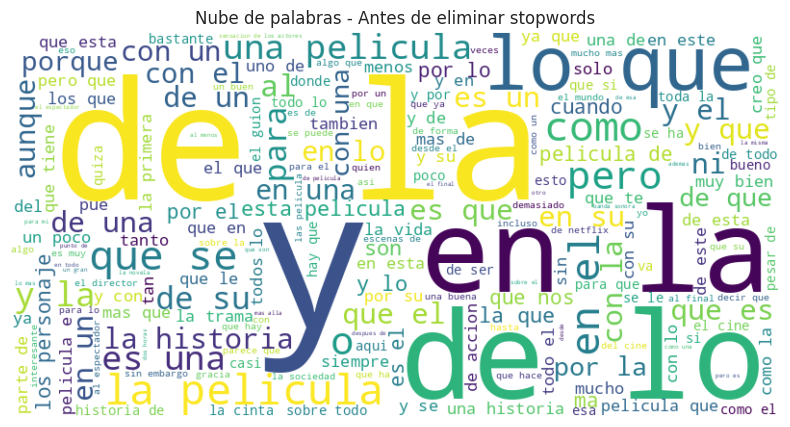

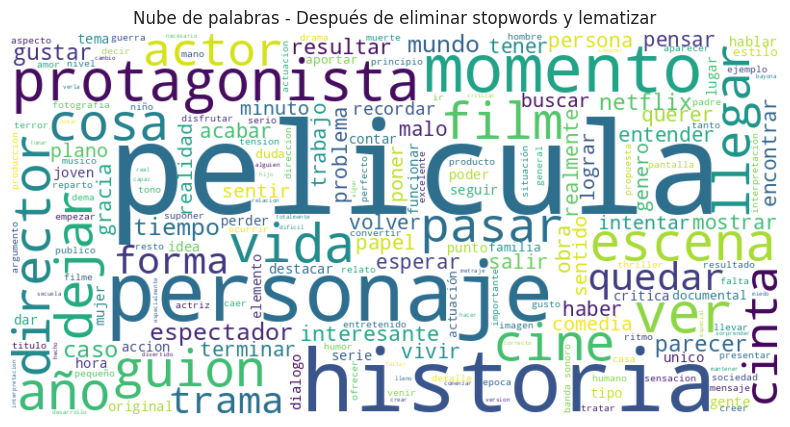

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Nube de palabras antes de eliminar stopwords (clean_review)
text_before = " ".join(df["clean_review"])
wc_before = WordCloud(width=800, height=400, background_color="white").generate(text_before)

plt.figure(figsize=(10,5))
plt.imshow(wc_before, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Antes de eliminar stopwords")
plt.show()

# Nube de palabras después de eliminar stopwords y lematizar (final_clean)
text_after = " ".join(df["final_clean"])
wc_after = WordCloud(width=800, height=400, background_color="white").generate(text_after)

plt.figure(figsize=(10,5))
plt.imshow(wc_after, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Después de eliminar stopwords y lematizar")
plt.show()


**Visualización de términos frecuentes**

Se genera una nube de palabras a partir de la columna `final_clean`, que permite observar visualmente los conceptos más recurrentes en las reseñas.

Esta visualización confirma que el corpus está centrado en contenido semántico relevante, sin interferencias de palabras funcionales ni lemas corruptos.


In [ ]:
print("Número total de reseñas:", len(df["final_clean"]))


Número total de reseñas: 5327


**TF‑IDF (Term Frequency – Inverse Document Frequency)**
- Representa cada documento como un vector de frecuencias ponderadas de palabras.

- Cada dimensión corresponde a una palabra del vocabulario.
- Limitación: si se pierde una dimensión (una palabra), se pierde toda la información asociada a ella. No hay contexto ni relación semántica entre palabras.

- Ejemplo: “película” y “film” son vectores distintos, aunque signifiquen lo mismo.

**Embeddings**
- Son representaciones densas y continuas de palabras o documentos en un espacio vectorial.
- Capturan contexto y relaciones semánticas: palabras similares quedan cerca en el espacio.
- Ventaja: si se pierde una dimensión del vector, la información no se destruye porque está distribuida en todas las dimensiones.
- Ejemplo: “película” y “film” tendrán vectores cercanos, porque aparecen en contextos similares.

In [ ]:
from google.colab import userdata
import google.generativeai as genai

# Recuperar la clave desde los secretos (si la guardaste allí)
api_key = userdata.get("GEMINI_API_KEY")  # o reemplaza con tu clave directamente
genai.configure(api_key=api_key)

# Verificar acceso: listar modelos disponibles
try:
    models = genai.list_models()
    print("✅ Conexión exitosa. Modelos disponibles:")
    for model in models:
        print("-", model.name)
except Exception as e:
    print("❌ Error al conectar con la API Gemini:")
    print(e)


✅ Conexión exitosa. Modelos disponibles:
- models/embedding-gecko-001
- models/gemini-2.5-pro-preview-03-25
- models/gemini-2.5-flash-preview-05-20
- models/gemini-2.5-flash
- models/gemini-2.5-flash-lite-preview-06-17
- models/gemini-2.5-pro-preview-05-06
- models/gemini-2.5-pro-preview-06-05
- models/gemini-2.5-pro
- models/gemini-2.0-flash-exp
- models/gemini-2.0-flash
- models/gemini-2.0-flash-001
- models/gemini-2.0-flash-lite-001
- models/gemini-2.0-flash-lite
- models/gemini-2.0-flash-lite-preview-02-05
- models/gemini-2.0-flash-lite-preview
- models/gemini-2.0-pro-exp
- models/gemini-2.0-pro-exp-02-05
- models/gemini-exp-1206
- models/gemini-2.0-flash-thinking-exp-01-21
- models/gemini-2.0-flash-thinking-exp
- models/gemini-2.0-flash-thinking-exp-1219
- models/gemini-2.5-flash-preview-tts
- models/gemini-2.5-pro-preview-tts
- models/learnlm-2.0-flash-experimental
- models/gemma-3-1b-it
- models/gemma-3-4b-it
- models/gemma-3-12b-it
- models/gemma-3-27b-it
- models/gemma-3n-e4b-

In [ ]:
import google.generativeai as genai
from google.colab import userdata

# Recuperar la clave desde los secretos
api_key = userdata.get("GEMINI_API_KEY")
genai.configure(api_key=api_key)

# Texto de prueba
texto = "Esta película tiene una trama muy interesante y personajes bien construidos."

# Solicitud de embedding
response = genai.embed_content(
    model="models/embedding-001",
    content=texto,
    task_type="semantic_similarity"
)

# Mostrar resultados
vector = response['embedding']
print("✅ Modelo funcionando. Dimensión del embedding:", len(vector))
print("Primeros valores del vector:", vector[:10])


TooManyRequests: 429 POST https://generativelanguage.googleapis.com/v1beta/models/embedding-001:embedContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/embed_content_free_tier_requests, limit: 0
* Quota exceeded for metric: generativelanguage.googleapis.com/embed_content_free_tier_requests, limit: 0
* Quota exceeded for metric: generativelanguage.googleapis.com/embed_content_free_tier_requests, limit: 0
* Quota exceeded for metric: generativelanguage.googleapis.com/embed_content_free_tier_requests, limit: 0

In [ ]:
import google.generativeai as genai
from google.colab import userdata

# Recuperar la clave desde los secretos de Colab
api_key = userdata.get("GEMINI_API_KEY")
genai.configure(api_key=api_key)

# Texto de prueba sencillo
texto = "Me encantó la actuación y la fotografía de esta película."

# Solicitud de embedding con el modelo gratuito
response = genai.embed_content(
    model="models/gemini-embedding-1.0",
    content=texto,
    task_type="semantic_similarity"
)

# Mostrar resultados básicos
vector = response['embedding']
print("✅ Modelo funcionando en free tier")
print("Dimensión del embedding:", len(vector))
print("Primeros valores:", vector[:10])


In [ ]:
import google.generativeai as genai
from google.colab import userdata

# Recuperar la clave desde los secretos de Colab
api_key = userdata.get("GEMINI_API_KEY")
genai.configure(api_key=api_key)

# Texto de prueba
texto = "Me encantó la actuación y la fotografía de esta película."

# Solicitud de embedding con un modelo válido
response = genai.embed_content(
    model="models/text-embedding-004",
    content=texto,
    task_type="semantic_similarity"
)

vector = response['embedding']
print("Modelo funcionando")
print("Dimensión del embedding:", len(vector))
print("Primeros valores:", vector[:10])


# **División de los datos antes de la generación de embeddings**

División inicial de los datos en entrenamiento y prueba.


In [ ]:
# División inicial de los datos en entrenamiento y prueba y entrenamiento y validación.
X = df['final_clean']  # textos (reseñas limpias)
y = df['gender']       # etiquetas (género asociado a la reseña)


In [ ]:
y.value_counts()


In [ ]:
# 1.División inicial: Train + Test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2.Subdivisión del Train en Train + Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2, random_state=42
)

# 2. Crear DataFrame de entrenamiento
train_df = pd.DataFrame({"text": X_train, "label": y_train})

In [ ]:
# Total de reseñas
total = len(X)

# Tamaños de cada conjunto
train_full_size = len(X_train_full)
test_size = len(X_test)
train_size = len(X_train)
val_size = len(X_val)

# Calcular porcentajes
print("Total reseñas:", total)
print(f"Train full: {train_full_size} ({train_full_size/total*100:.2f}%)")
print(f"Test: {test_size} ({test_size/total*100:.2f}%)")
print(f"Train: {train_size} ({train_size/total*100:.2f}%)")
print(f"Validation: {val_size} ({val_size/total*100:.2f}%)")

print("Train DataFrame:", train_df.shape)  # filas y columnas


### División de datos y problema con `stratify`

Al intentar dividir el dataset en entrenamiento, validación y prueba usando:

```python
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
```
se generó el siguiente error:

```python
ValueError: The least populated class in y has only 1 member, which is too few.
```

- La opción `stratify=y` intenta mantener la proporción de clases en cada conjunto.
- Para lograrlo, cada clase debe tener al menos 2 ejemplos (uno para train y otro para test).
- En este dataset, algunas combinaciones de géneros aparecen solo una vez, lo que hace imposible estratificar.

**Alternativas :**
1.  Eliminar clases con muy pocos ejemplos
- Filtrar aquellas con menos de 2 muestras.
- Problema: se perdería información valiosa y el dataset quedaría aún más
reducido.

2. Agrupar clases raras en una categoría `“Otros”`
- Permite conservar los ejemplos pero se pierde granularidad.
- Problema: el modelo no aprendería las combinaciones originales.

3. No usar stratify
- La división se hace aleatoriamente, sin garantizar proporciones exactas.
- Riesgo: puede haber cierto desbalance entre train, val y test.
- Ventaja: se conservan todas las clases, incluso las minoritarias.

**Decisión tomada :**
Se optó por **eliminar** `stratify` en el `train_test_split`.

De esta forma:
- Se mantienen todas las clases, incluso las que aparecen una sola vez.
- El modelo podrá aprender de ellas, aunque sean minoritarias.
- Si aparecen problemas de desbalance, se pueden aplicar técnicas posteriores en el entrenamiento y validación, como:
  - Reponderación de clases (`class_weight`).
  - Oversampling/undersampling (SMOTE, RandomOverSampler).
  - Evaluación con métricas robustas (F1-score, balanced accuracy).


**Conclusión :**

La eliminación de `stratify` fue necesaria para conservar la totalidad del dataset. Aunque esto introduce el riesgo de desbalance, dicho problema puede abordarse en la fase de entrenamiento y validación con técnicas específicas de balanceo y métricas adecuadas.

**Resultado :**

- **Train/Test split (80/20):**
  - 80% de reseñas para entrenamiento.
  - 20% para prueba final (evaluación del modelo).
  
- **Train/Validation split (80/20 del train):**
  - Del 80% inicial, se toma 20% para validación.
  - Resultado final:
    - Train: 64% del total.
    - Validation: 16% del total.
    - Test: 20% del total.


## **Vectorización - Embeddings**

- Generar embeddings por lotes en cada conjunto (X_train, X_val, X_test).
  - Cada reseña se convierte en un vector de 768 dimensiones.
  - Guardar los embeddings en nuevas variables o columnas.

- Entrenar el clasificador usando X_train_embeddings y y_train.
- Validar con X_val_embeddings y y_val.
- Evaluar con X_test_embeddings y y_test.

In [ ]:
import google.generativeai as genai
from google.colab import userdata

# Configurar la API
api_key = userdata.get("GEMINI_API_KEY")
genai.configure(api_key=api_key)

# Crear DataFrame de entrenamiento si aún no lo tienes
train_df = pd.DataFrame({"text": X_train, "label": y_train})

# Crear columna de embeddings si no existe
if "embedding_vector" not in train_df.columns:
    train_df["embedding_vector"] = None

# Detectar cuántas reseñas ya tienen embeddings
procesadas = train_df["embedding_vector"].notna().sum()
print("Reseñas ya procesadas:", procesadas)

# Definir lote diario (máximo 1000)
lote = 1000
start_index = procesadas
end_index = min(start_index + lote, len(train_df))

print(f"Procesando reseñas {start_index} a {end_index-1}")

embeddings = []
for texto in train_df["text"].iloc[start_index:end_index]:
    try:
        response = genai.embed_content(
            model="models/text-embedding-004",
            content=texto,
            task_type="semantic_similarity"
        )
        embeddings.append(response['embedding'])
    except Exception as e:
        print(f"Error en reseña {i}: {e}")
        embeddings.append(None)

# Guardar embeddings en el DataFrame
train_df.loc[start_index:end_index, "embedding_vector"] = embeddings

# Exportar para no perder progreso
train_df.to_csv("X_train_embeddings.csv", index=False)

print(f"✅ Embeddings guardados para reseñas {start_index} a {end_index-1}")


### Generación de embeddings optimizada con `text-embedding-004`

Este bloque de código implementa un pipeline para convertir las reseñas de entrenamiento en **vectores de embeddings** de 768 dimensiones utilizando el modelo `text-embedding-004`.  
El objetivo es procesar las reseñas en **lotes diarios de máximo 1000**, respetando la cuota de la API y asegurando reproducibilidad.

#### Funcionamiento paso a paso

1. **Configuración de la API**  
   - Se importa la librería `google.generativeai` y se configura la clave de acceso (`GEMINI_API_KEY`).  
   - Esto habilita el uso del modelo de embeddings.

2. **Creación del DataFrame de entrenamiento**  
   - Se construye `train_df` con dos columnas:  
     - `text`: las reseñas limpias (`X_train`).  
     - `label`: las etiquetas asociadas (`y_train`).  
   - Se añade la columna `embedding_vector` para almacenar los embeddings.

3. **Detección de progreso previo**  
   - Se cuenta cuántas reseñas ya tienen embeddings (`.notna().sum()`).  
   - Esto permite continuar automáticamente desde donde se dejó en ejecuciones anteriores.

4. **Definición del lote diario**  
   - Se fija un máximo de **1000 reseñas por día**.  
   - Se calculan los índices `start_index` y `end_index` para determinar qué reseñas procesar en la ejecución actual.

5. **Generación de embeddings**  
   - Se recorre el rango de reseñas del lote.  
   - Cada reseña se convierte en un vector de 768 dimensiones mediante `genai.embed_content`.  
   - En caso de error, se registra y se asigna `None`.

6. **Almacenamiento de resultados**  
   - Los embeddings generados se guardan en la columna `embedding_vector` del DataFrame.  
   - Se exporta el DataFrame completo a un archivo CSV (`X_train_embeddings.csv`) para no perder el progreso.

7. **Confirmación de progreso**  
   - Se imprime un mensaje indicando el rango de reseñas procesadas y confirmando que los embeddings fueron guardados.

#### Ventajas de este enfoque
- **Automatización:** no es necesario modificar manualmente los índices cada día.  
- **Reproducibilidad:** el progreso queda registrado en el CSV, permitiendo continuar sin repetir reseñas.  
- **Escalabilidad:** se adapta a corpus grandes respetando las cuotas de la API.  
- **Seguridad:** maneja errores individuales sin interrumpir todo el proceso.

#### Resultado esperado
Al finalizar cada ejecución, se habrán generado y guardado los embeddings para un lote de hasta 1000 reseñas de entrenamiento.  
En sucesivas ejecuciones, el código detectará automáticamente cuántas reseñas ya están procesadas y continuará con las siguientes hasta completar las 3408 reseñas de entrenamiento.
